# Import

In [13]:
# Work with paths
import sys
sys.path.append('..')

# import implemented modules
import src.config as cfg
from src.data import make_dataset
import src.utils as utils

# import other modules
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier, metrics, Pool

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import sklearn

# Generate Dataset

In [3]:
! python3 ../src/data/make_dataset.py                           \
    --input_filepath=../data/raw/train.csv                      \
    --output_data_filepath=../data/processed/train_data.pkl     \
    --output_target_filepath=../data/processed/target_data.pkl

2022-10-15 23:31:16,070 - __main__ - INFO - making final data set from raw data
2022-10-15 23:31:16,096 - __main__ - INFO - Target saved to ../data/processed/target_data.pkl
2022-10-15 23:31:16,096 - __main__ - INFO - Dataset saved to ../data/processed/train_data.pkl


In [4]:
! python3 ../src/data/make_dataset.py                           \
    --input_filepath=../data/raw/test.csv                       \
    --input_target_filepath=../data/raw/sample_solution.csv     \
    --output_data_filepath=../data/processed/val_data.pkl       \
    --output_target_filepath=../data/processed/val_target.pkl

2022-10-15 23:31:16,773 - __main__ - INFO - making final data set from raw data
2022-10-15 23:31:16,799 - __main__ - INFO - Target saved to ../data/processed/val_target.pkl
2022-10-15 23:31:16,799 - __main__ - INFO - Dataset saved to ../data/processed/val_data.pkl


Load dataset

In [5]:
train_data  = pd.read_pickle(str(os.getcwd() + "/../data/processed/train_data.pkl"))
target_data = pd.read_pickle(str(os.getcwd() + "/../data/processed/target_data.pkl"))

val_data   = pd.read_pickle(str(os.getcwd() + "/../data/processed/val_data.pkl"))
val_target = pd.read_pickle(str(os.getcwd() + "/../data/processed/val_data.pkl"))

Save transformation pipeline and collect embeddings

In [6]:
full_data = pd.concat([train_data, val_data])
full_data.drop(cfg.TARGET_COLS, axis=1, inplace=True)

Transformer = utils.preprocess_pipe.fit(full_data)
utils.save_encoder(Transformer, str(os.getcwd() + "/../data/Transformer.pkl"))
Transformer = utils.load_encoder(str(os.getcwd() + "/../data/Transformer.pkl"))

Visualize data

/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

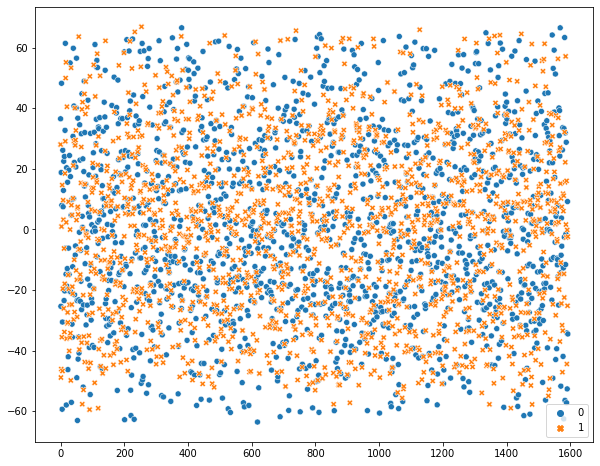

In [8]:
full_data_copy = Transformer.transform(full_data).copy()

tsne = TSNE(n_components=2, random_state=cfg.RANDOM_STATE, perplexity=15, n_iter=1000, verbose=0)
tsne_representation = tsne.fit_transform(full_data_copy)

plt.figure(figsize=(10,8))
sns.scatterplot(data=pd.DataFrame(tsne_representation))

/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_81481/3825899546.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0.5, 0, 'Z Label')

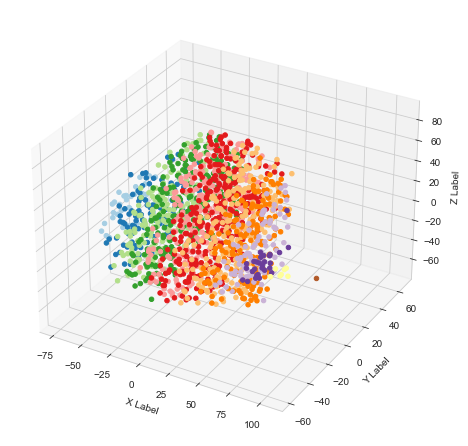

In [9]:
tsne = TSNE(n_components=3, random_state=cfg.RANDOM_STATE, perplexity=30, n_iter=1000)
tsne_representation = tsne.fit_transform(full_data_copy)



import seaborn as sns, numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)
x = tsne_representation[:, 0]
y = tsne_representation[:, 1]
z = tsne_representation[:, 2]

g = ax.scatter(x, y, z, c=x, marker='o', depthshade=False, cmap='Paired')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

If we want to predict illness, we are interested in not getting FalseNegative that is why function is Recall

Generate tran and test selections

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    Transformer.transform(train_data), 
                                                    target_data, 
                                                    train_size=0.8, 
                                                    random_state=cfg.RANDOM_STATE, 
                                                    stratify=target_data.iloc[:,[1, 2, 3, 4]].sum(axis=1)
                                                    )

Generate features

In [9]:
None

Catboost

In [14]:
train_pool = Pool(X_train, Y_train)
test_pool = Pool(X_test, Y_test)


model = CatBoostClassifier(
    loss_function='MultiLogloss',
    eval_metric='HammingLoss',
    iterations=500,
)

model.fit(train_pool, 
        eval_set=test_pool, 
        metric_period=10, 
        plot=True, 
        verbose=50,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.040085
0:	learn: 0.1277487	test: 0.1308901	best: 0.1308901 (0)	total: 62.5ms	remaining: 31.2s
50:	learn: 0.1193717	test: 0.1287958	best: 0.1267016 (20)	total: 280ms	remaining: 2.46s
100:	learn: 0.1096859	test: 0.1267016	best: 0.1256545 (90)	total: 497ms	remaining: 1.96s
150:	learn: 0.0989529	test: 0.1267016	best: 0.1256545 (90)	total: 719ms	remaining: 1.66s
200:	learn: 0.0924084	test: 0.1277487	best: 0.1256545 (90)	total: 941ms	remaining: 1.4s
250:	learn: 0.0795812	test: 0.1277487	best: 0.1256545 (90)	total: 1.17s	remaining: 1.16s
300:	learn: 0.0636126	test: 0.1277487	best: 0.1256545 (90)	total: 1.42s	remaining: 940ms
350:	learn: 0.0471204	test: 0.1329843	best: 0.1256545 (90)	total: 1.64s	remaining: 695ms
400:	learn: 0.0374346	test: 0.1329843	best: 0.1256545 (90)	total: 1.85s	remaining: 457ms
450:	learn: 0.0280105	test: 0.1319372	best: 0.1256545 (90)	total: 2.07s	remaining: 225ms
499:	learn: 0.0212042	test: 0.1319372	best: 0.1256545 (90)	total: 2.28s	remaining: 0